# Recurrent neural networks (RNN)

In [72]:
#spacy works for python 3.8.10
import spacy
#!python3.8 -m spacy download en_core_web_sm
import os
import ast

#word2vec
from gensim.models import Word2Vec
from gensim import downloader

import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("pastel"))

#modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Embedding, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, Accuracy

import datetime

#saving model
import pickle

### Functions and global vars definition

In [4]:
DEVELOPING = False
MAX_LENGTH = 80

In [5]:
nlp = spacy.load("en_core_web_sm")#english tokenizer, tagger, parser and NER
def split_sentences(text):
    aux_sentence = nlp(text)
    return [str(token.lemma_).lower() for token in aux_sentence if not (token.is_stop or \
                                                                token.is_punct or \
                                                                len(token)<3)]

def encoding_data(data_train,data_test,max_length):
    """This function creates the tokenizer, fits it to the data, tokenizes and padds train and test dataframes,
    saves the fitted tokenizer into a file, and finally returns train and test dataframes with text encoded as well as 
    the labels one hot encoded and the word_index dictionary"""
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data_train["preprocessed_content"])

    # word_index is a dictionary contains indeces for the words like {'for': 8, 'is': 9, 'me': 10, ...}
    word_index = tokenizer.word_index

    # train_sequences is vectors where each vector represents a sentence
    train_sequences = tokenizer.texts_to_sequences(data_train["preprocessed_content"])
    test_sequences = tokenizer.texts_to_sequences(data_test["preprocessed_content"])

    train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding="pre")
    test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding="pre")

    # Convert our labels into one-hot encoded
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoder.fit(np.array(data_train["label"]).reshape(-1, 1))

    train_labels = onehot_encoder.transform(np.array(data_train["label"]).reshape(-1, 1))
    test_labels = onehot_encoder.transform(np.array(data_test["label"]).reshape(-1, 1))


    # saving
    with open('data/tokenizers_embedders/tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


    return train_sequences, test_sequences, train_labels, test_labels, word_index

def embeddingWights(w2v, word_index, max_num_words=500000):
  
  all_embs = np.stack(w2v.wv.vectors)
  emb_mean,emb_std = all_embs.mean(), all_embs.std()

  num_words = min(max_num_words, len(word_index))+1

  embedding_dim=len(w2v.wv['software'])

  embedding_wights = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))

  for word, i in word_index.items():
    if i >= max_num_words:
        break

    if word in w2v.wv:
        embedding_vector = w2v.wv[word]
        embedding_wights[i] = embedding_vector
    
  return embedding_wights, num_words

def build_RNN_model(input_size, num_words, output_dim, embedding_wights,metrics_list):

    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=output_dim, trainable=True, input_length=input_size, weights=[embedding_wights]))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2, dropout=0.2), 'concat'))
    model.add(Dropout(0.4))
    model.add(LSTM(64, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
    model.add(Dropout(0.4))
    model.add(LSTM(32, return_sequences=False, recurrent_dropout=0.2, dropout=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(14, activation='softmax'))
    model.compile(loss ='categorical_crossentropy', optimizer = "adam", metrics = metrics_list)


    return model


In [5]:
data_train = pd.read_csv("data/csv/clean_df_train.csv")
data_test = pd.read_csv("data/csv/clean_df_test.csv")

In [6]:
#subsampling for developing faster
if DEVELOPING:
    data_train = data_train.groupby('label').apply(lambda x: x.sample(frac=0.03)).reset_index(drop=True)
    data_test = data_test.groupby('label').apply(lambda x: x.sample(frac=0.03)).reset_index(drop=True)

## preprocessing

### Analyzing length of each sentence

With a length of input of 80 words we are only not completely getting approximatelly a 5% of the data (train and test)

In [7]:
data_train["words_count"] = data_train.apply(lambda row: len(row["content"].split()), axis = 1)
data_test["words_count"] = data_test.apply(lambda row: len(row["content"].split()), axis = 1)

In [8]:
data_train["words_count"].describe()

count    11573.000000
mean        45.155966
std         24.755010
min          2.000000
25%         24.000000
50%         44.000000
75%         65.000000
max       1175.000000
Name: words_count, dtype: float64

In [9]:
data_test["words_count"].describe()

count    1443.000000
mean       45.778933
std        23.077126
min         6.000000
25%        24.000000
50%        44.000000
75%        67.000000
max       179.000000
Name: words_count, dtype: float64

In [10]:
"""#parallelizing (Not sure it works correctly. Maybe mac hardware is not good for this)
import dask.dataframe as dd
from dask.multiprocessing import get

ddata = dd.from_pandas(data_train, npartitions=30)

#data_train[:1000].apply(lambda row: split_sentences(row["content"]), axis = 1)
ddata.map_partitions(lambda df: df.apply((lambda row: split_sentences(row["content"])), axis=1)).compute(scheduler="threads")"""

0        [ware, label, himeyasoft, inc., confuse, distr...
1        [octapharma, large, privately, own, human, pro...
2        [knoll, aircraft, company, american, aircraft,...
3        [middletown, area, transit, popularly, know, m...
4        [fabrap, finch, alexander, barnes, rothschild,...
                               ...                        
11568    [journal, gazette, morning, newspaper, fort, w...
11569    [scandia, academic, journal, history, publish,...
11570    [central, european, journal, mathematics, peer...
11571    [grey, japanese, science, fiction, manga, crea...
11572    [kindly, ones, french, les, bienveillantes, hi...
Length: 11573, dtype: object

In [11]:
data_train["preprocessed_content"] = data_train.apply(lambda row: split_sentences(row["content"]), axis = 1)
data_test["preprocessed_content"] = data_test.apply(lambda row: split_sentences(row["content"]), axis = 1)

In [12]:
data_train.head()

,label,title,content,words_count,preprocessed_content
0,0.0,C's Ware,C's Ware is a label of HimeyaSoft Inc. (not t...,77,"[ware, label, himeyasoft, inc., confuse, distr..."
1,0.0,Octapharma,Octapharma AG is the largest privately owned ...,68,"[octapharma, large, privately, own, human, pro..."
2,0.0,Knoll Aircraft Company,Knoll Aircraft Company was an American aircra...,12,"[knoll, aircraft, company, american, aircraft,..."
3,0.0,Middletown Area Transit,Middletown Area Transit popularly known as MA...,73,"[middletown, area, transit, popularly, know, m..."
4,0.0,FABRAP,FABRAP or Finch Alexander Barnes Rothschild a...,32,"[fabrap, finch, alexander, barnes, rothschild,..."


In [13]:
data_test.head()

,label,title,content,words_count,preprocessed_content
0,0,SemBioSys Genetics,SemBioSys Genetics Inc. was a development sta...,46,"[sembiosys, genetics, inc., development, stage..."
1,0,Element Six,Element Six (formerly De Beers Industrial Dia...,57,"[element, beers, industrial, diamond, company,..."
2,0,NBTY,NBTY Inc. formerly known as Nature's Bounty I...,56,"[nbty, inc., know, nature, bounty, inc., ameri..."
3,0,Pinkberry,Pinkberry is a franchise of upscale frozen de...,65,"[pinkberry, franchise, upscale, frozen, desser..."
4,0,Lam Research,Lam Research Corporation is an American corpo...,27,"[lam, research, corporation, american, corpora..."


### Saving preprocessed dataframes to avoid repeating preprocessing

In [ ]:
data_train.to_csv('preprocessed_df_train.csv', index=False)
data_test.to_csv('preprocessed_df_test.csv', index=False)

## Tokenizer

In [4]:
data_train = pd.read_csv("data/csv/preprocessed_df_train.csv")
data_test = pd.read_csv("data/csv/preprocessed_df_test.csv")

In [20]:
data_train["preprocessed_content"] = data_train.apply(lambda row: ast.literal_eval(row["preprocessed_content"]), axis = 1)
data_test["preprocessed_content"] = data_test.apply(lambda row: ast.literal_eval(row["preprocessed_content"]), axis = 1)

In [21]:
train_sequences, test_sequences, train_labels, test_labels, word_index = encoding_data(data_train, data_test, MAX_LENGTH)

#Saving all information so we dont need to process them again
with open("data/tokenizers_embedders/train_sequences.pickle","wb") as file:
    pickle.dump(train_sequences,file)
with open("data/tokenizers_embedders/test_sequences.pickle","wb") as file:
    pickle.dump(test_sequences,file)
with open("data/tokenizers_embedders/train_labels.pickle","wb") as file:
    pickle.dump(train_labels,file)
with open("data/tokenizers_embedders/test_labels.pickle","wb") as file:
    pickle.dump(test_labels,file)
with open("data/tokenizers_embedders/word_index.pickle","wb") as file:
    pickle.dump(word_index,file)

In [22]:
# loading
with open('data/tokenizers_embedders/tokenizer.pickle', 'rb') as file:
    tokenizer = pickle.load(file)
with open("data/tokenizers_embedders/train_sequences.pickle","rb") as file:
    train_sequences = pickle.load(file)
with open("data/tokenizers_embedders/train_sequences.pickle","rb") as file:
    test_sequences = pickle.load(file)
with open("data/tokenizers_embedders/train_labels.pickle","rb") as file:
    train_labels = pickle.load(file)
with open("data/tokenizers_embedders/test_labels.pickle","rb") as file:
    test_labels = pickle.load(file)
with open("data/tokenizers_embedders/word_index.pickle","rb") as file:
    word_index = pickle.load(file)

# Defnining word embedding

### Creating our own word embedding with Word2vec

+ min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
+ window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
+ size = int - Dimensionality of the feature vectors. - (50, 300)
+ sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
+ alpha = float - The initial learning rate - (0.01, 0.05)
min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
+ negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
+ workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [23]:
#total words in our vocabulary
len(word_index.keys())

416506

In [24]:
data_train

,label,title,content,words_count,preprocessed_content,preprocessing
0,0.0,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...,40,"[abbott, farnham, abbott, limited, british, co...","[abbott, farnham, abbott, limited, british, co..."
1,0.0,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...,32,"[schwan, stabilo, german, maker, pen, write, c...","[schwan, stabilo, german, maker, pen, write, c..."
2,0.0,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...,29,"[marvell, software, solutions, israel, know, r...","[marvell, software, solutions, israel, know, r..."
3,0.0,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...,19,"[bergan, mercy, medical, center, hospital, loc...","[bergan, mercy, medical, center, hospital, loc..."
4,0.0,The Unsigned Guide,The Unsigned Guide is an online contacts dire...,37,"[unsigned, guide, online, contact, directory, ...","[unsigned, guide, online, contact, directory, ..."
...,...,...,...,...,...,...
385744,13.0,Scoliosis (journal),Scoliosis (ISSN 1748-7161) is an open-access ...,60,"[scoliosis, issn, 1748, 7161, open, access, pe...","[scoliosis, issn, 1748, 7161, open, access, pe..."
385745,13.0,Barking in Essex,Barking in Essex is a Black comedy play direc...,34,"[bark, essex, black, comedy, play, direct, har...","[bark, essex, black, comedy, play, direct, har..."
385746,13.0,Science & Spirit,Science & Spirit is a discontinued American b...,66,"[science, spirit, discontinued, american, bimo...","[science, spirit, discontinued, american, bimo..."
385747,13.0,The Blithedale Romance,The Blithedale Romance (1852) is Nathaniel Ha...,27,"[blithedale, romance, 1852, nathaniel, hawthor...","[blithedale, romance, 1852, nathaniel, hawthor..."


In [25]:
w2v_model = Word2Vec(sentences= data_train["preprocessed_content"].to_list(),
                     min_count=3,
                     window=10,
                     vector_size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007)

In [29]:
w2v_model.save("data/models/word2vec.model")

In [30]:
#total words in our word embedding ignoring words that appear less than 3 times
len(w2v_model.wv)

124152

In [32]:
embedding_wights, num_words = embeddingWights(w2v_model, word_index, max_num_words=500000)

In [33]:
# testing the word embedding by comparing the weights of the final 
# embedding_wights and w2v_model.wv vector for the word "software", 
# they should be the same so the result should be 0.

(embedding_wights[word_index["school"],:].reshape([100,1])-w2v_model.wv["school"].reshape([100,1])).sum()

0.0

In [35]:
#saving embedding weights
np.save('data/models/embedding_layer_weights.npy', embedding_wights)
np.save('data/models/num_words.npy', num_words)

### Visualizing word embedding

In [48]:
#loading previously trained model
w2v_model = Word2Vec.load("data/models/word2vec.model")

In [49]:
#testing similarities
word = 'software'
print(f"3 words similar to **{word}**")
words = w2v_model.wv.most_similar(word, topn=3)
for word in words:
  print(word)

3 words similar to **software**
('computer', 0.8293694257736206)
('linux', 0.8119499087333679)
('microsoft', 0.8118927478790283)


In [50]:
#testing similarities
word = 'school'
print(f"3 words similar to **{word}**")
words = w2v_model.wv.most_similar(word, topn=3)
for word in words:
  print(word)

3 words similar to **school**
('high', 0.7755335569381714)
('secondary', 0.7312402129173279)
('grade', 0.7299057841300964)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


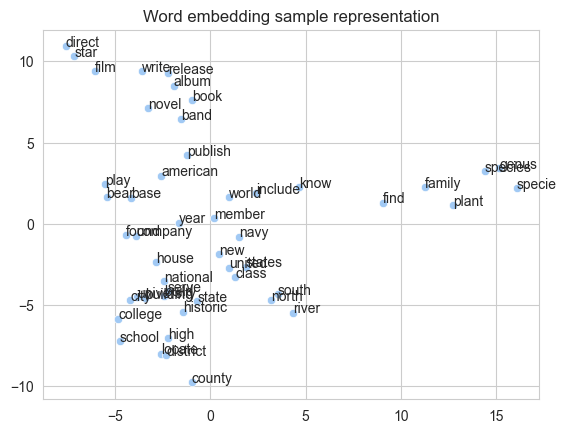

In [74]:
from sklearn.decomposition import PCA

words_to_represent = 50

pca = PCA(n_components=2)
result = pca.fit_transform(w2v_model.wv.vectors[:words_to_represent])
word_embedding_fig = sns.scatterplot(result[:,0],result[:,1])

words = list(w2v_model.wv.key_to_index.keys())[:words_to_represent]

for i in range(words_to_represent):
   word_embedding_fig.annotate(words[i], xy = (result[i, 0], result[i, 1]))

word_embedding_fig.set_title('Word embedding sample representation')

plt.savefig("data/results/figures/word_embedding.png")

# Training

### Data separation

In [9]:
#loading datasets
with open("data/tokenizers_embedders/train_sequences.pickle","rb") as file:
    train_sequences = pickle.load(file)
with open("data/tokenizers_embedders/test_sequences.pickle","rb") as file:
    test_sequences = pickle.load(file)
with open("data/tokenizers_embedders/train_labels.pickle","rb") as file:
    train_labels = pickle.load(file)
with open("data/tokenizers_embedders/test_labels.pickle","rb") as file:
    test_labels = pickle.load(file)

In [10]:
#loading files for training the model
embedding_wights = np.load("data/models/embedding_layer_weights.npy")
num_words = np.load("data/models/num_words.npy")

In [11]:
embedding_wights.shape

(416507, 100)

In [12]:
num_words

array(416507)

In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(train_sequences, 
                                                                  train_labels,
                                                                  test_size = 0.2)
test_data = test_sequences
test_labels = test_labels

In [14]:
#Creation of callbacks
model_name = "RNN_model"
dest_path="data/models/tensorflow_outputs"

log_dir = dest_path + "/logs/fit/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                mode='min', 
                                                patience = 5, 
                                                verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir,
                                                        histogram_freq = 1)

checkpoint_path_best = os.path.join(dest_path,model_name + "_best.hdf5")
checkpoint_path_last = os.path.join(dest_path,model_name + "_last.hdf5")

cp_callback_best = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_best,
                                                save_best_only=True,
                                                monitor = "val_loss",
                                                mode = "min",
                                                verbose=1)

cp_callback_last = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path_last,
                                                    verbose = 0,
                                                    save_freq = 'epoch')

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', patience = 5, mode = "min", verbose = 1, factor = 0.1, min_delta=0.001, min_lr = 0.00001)

callbacks_list = [cp_callback_best, cp_callback_last, es_callback, tensorboard_callback]

metrics_list = ["Accuracy", "Precision", "Recall"]

In [ ]:
#creating the model
RNN_model = build_RNN_model(MAX_LENGTH, num_words, 100, embedding_wights, metrics_list)
RNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 80, 100)           41650700  
                                                                 
 batch_normalization (BatchN  (None, 80, 100)          400       
 ormalization)                                                   
                                                                 
 bidirectional_1 (Bidirectio  (None, 80, 512)          731136    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 80, 512)           0         
                                                                 
 lstm_4 (LSTM)               (None, 80, 64)            147712    
                                                                 
 dropout_5 (Dropout)         (None, 80, 64)           

In [ ]:
history = RNN_model.fit(train_data, train_labels, epochs = 50,
          batch_size = 1512, shuffle=True,
          validation_data=[val_data, val_labels],
          callbacks = callbacks_list,
          verbose = 1,
          use_multiprocessing=True
          )

Epoch 1/50
205/205 [==============================] - ETA: 0s - loss: 1.1226 - Accuracy: 0.8502 - precision: 0.9701 - recall: 0.3303
Epoch 00001: val_loss improved from inf to 0.43931, saving model to data\models\tensorflow_outputs\RNN_model_best.hdf5
205/205 [==============================] - 1065s 5s/step - loss: 1.1226 - Accuracy: 0.8502 - precision: 0.9701 - recall: 0.3303 - val_loss: 0.4393 - val_Accuracy: 0.9598 - val_precision: 0.9699 - val_recall: 0.9334
Epoch 2/50
205/205 [==============================] - ETA: 0s - loss: 0.3893 - Accuracy: 0.9606 - precision: 0.9763 - recall: 0.8975
Epoch 00002: val_loss improved from 0.43931 to 0.18296, saving model to data\models\tensorflow_outputs\RNN_model_best.hdf5
205/205 [==============================] - 967s 5s/step - loss: 0.3893 - Accuracy: 0.9606 - precision: 0.9763 - recall: 0.8975 - val_loss: 0.1830 - val_Accuracy: 0.9753 - val_precision: 0.9798 - val_recall: 0.9717
Epoch 3/50
205/205 [==============================] - ETA: 0s -

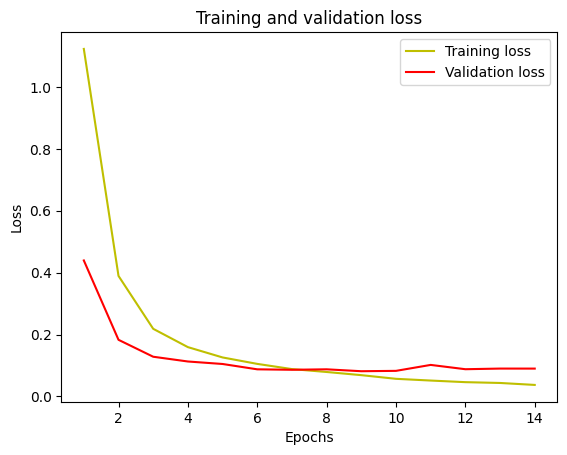

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Evaluation

In [18]:
#creating the model structure
RNN_model = build_RNN_model(MAX_LENGTH, num_words, 100, embedding_wights, metrics_list)

#loading weights
checkpoint_path = checkpoint_path_best
RNN_model.load_weights(checkpoint_path)
 

In [19]:
results = RNN_model.evaluate(test_sequences, test_labels, batch_size = 1512)
results

32/32 [==============================] - 68s 2s/step - loss: 0.0821 - Accuracy: 0.9839 - precision: 0.9854 - recall: 0.9831


[0.08208899199962616,
 0.9839349985122681,
 0.9853559732437134,
 0.9830828905105591]

In [20]:
F1score = 2*(results[2]*results[3])/(results[2]+results[3])
F1score

0.9842181194398524

In [21]:


print("Precision over test set: " + str(results[2]))
print("Recall over test set: " + str(results[3]))
print("Accuracy over test set: " + str(results[1]))
print("F1 over test set: " + str(F1score))

Precision over test set: 0.9853559732437134
Recall over test set: 0.9830828905105591
Accuracy over test set: 0.9839349985122681
F1 over test set: 0.9842181194398524


In [23]:
#creating a matrix with results for each class
test_labels.shape

(48117, 14)

In [34]:
results_matrix = np.zeros((4,14))

In [39]:
for i in range(14):
    y_test_class = test_labels[test_labels[:,i] == 1]
    x_test_class = test_sequences[test_labels[:,i] == 1]
    results = RNN_model.evaluate(x_test_class, y_test_class, batch_size = 1512)

    results_matrix[0,i] = results[1]#accuracy
    results_matrix[1,i] = results[2]#precision
    results_matrix[2,i] = results[3]#recall
    results_matrix[3,i] = 2*(results[2]*results[3])/(results[2]+results[3])#F1    

3/3 [==============================] - 6s 2s/step - loss: 0.0935 - Accuracy: 0.9816 - precision: 0.9838 - recall: 0.9811


In [44]:
classes =["Company","EducationalInstitution","Artist",
          "Athlete","OfficeHolder","MeanOfTransportation",
          "Building","NaturalPlace","Village","Animal","Plant",
          "Album","Film","WrittenWork"]

results_df = pd.DataFrame(results_matrix, columns = classes)
results_df.index = ["Accuracy", "Precision", "Recall", "F1score"]
results_df["global"] = results_df.apply(lambda row: row[classes].mean(), axis = 1)
results_df

,Company,EducationalInstitution,Artist,Athlete,OfficeHolder,MeanOfTransportation,Building,NaturalPlace,Village,Animal,Plant,Album,Film,WrittenWork,global
Accuracy,0.959764,0.981710,0.973383,0.992129,0.981466,0.987373,0.977267,0.991325,0.990836,0.990809,0.996811,0.989820,0.983306,0.981576,0.984113
Precision,0.961865,0.983979,0.975537,0.993246,0.983884,0.988349,0.978435,0.992014,0.991973,0.991254,0.997037,0.991185,0.985181,0.983834,0.985555
Recall,0.956689,0.980938,0.973013,0.992129,0.980642,0.987126,0.974769,0.991325,0.990836,0.990809,0.996355,0.988663,0.982485,0.981064,0.983346
F1score,0.959270,0.982456,0.974274,0.992687,0.982261,0.987737,0.976599,0.991670,0.991404,0.991031,0.996696,0.989922,0.983831,0.982447,0.984449


In [47]:
results_df.to_csv("data/models_results/RNN_metrics_results.csv")